In [147]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


#AAPL data from 2016-01-01 to 2016-12-01
df = yf.download('AAPL', start='2016-01-01', end='2016-12-01')

[*********************100%***********************]  1 of 1 completed


In [148]:
#1(A)

#Calculate M and initialize an array of price deviations. 
M = len(df) - 1  
price_diff_squared = []

#Loop for calculating price deviations. 
for k in range(1, len(df)):
    previous_close = df.iloc[k - 1]['Close'] 
    current_close = df.iloc[k]['Close']  
    diff_squared = (current_close - previous_close) ** 2
    price_diff_squared.append(diff_squared)

#Sigma squared calculation
sigma_squared = sum(price_diff_squared) / M
print("Estimated σ̂²:", sigma_squared)

Estimated σ̂²: 0.14927897282873542


In [149]:
#1(B)

#Calculation of ε, η, γ using average spread and average daily volume
avg_spread = 0.2
average_daily_volume = df['Volume'].mean()
epsilon = avg_spread / 2
eta = avg_spread / (0.0001 * average_daily_volume)
gamma = avg_spread / (0.001 * average_daily_volume)

print("Estimated parameters:")
print("ε =", epsilon)
print("η =", eta)
print("γ =", gamma)

Estimated parameters:
ε = 0.1
η = 1.272908762164999e-05
γ = 1.272908762164999e-06


In [150]:
#1(C) pt. 1


#λ's,  
lambda_values = [0.001, 0.0001]
kappa_values = []
T = 10
N = 10
tau = T / N

for lambda_val in lambda_values:
    #η̃ = η - (1/2) * γ * τ
    eta_tilde = eta - 0.5 * gamma * tau
    #κ̃² = (λ * σ²) / η̃
    kappa_hat_squared = (lambda_val * sigma_squared) / eta_tilde
    #κ = (1 / τ) * arccosh(1 + (τ² / 2) * κ̃²)
    kappa = (1 / tau) * np.arccosh(1 + (tau**2 / 2) * kappa_hat_squared)
    kappa_values.append(kappa)

#Print κ values
for i in range(len(kappa_values)):
    print("κ:", float(kappa_values[i]), "for λ =", lambda_values[i])

κ: 2.6584793673061053 for λ = 0.001
κ: 1.060643572305581 for λ = 0.0001


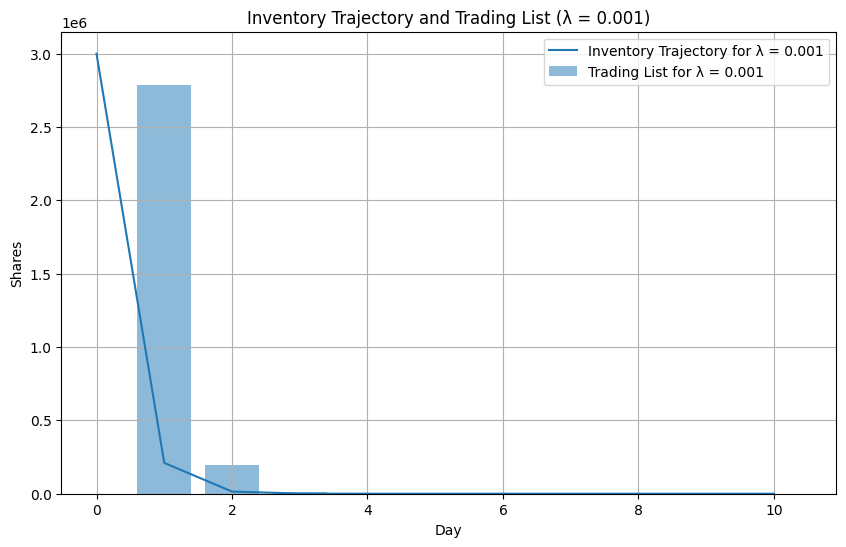

Time Step (t) | Inventory Trajectory (X_t) | Shares Traded (n_j) |  λ = 0.001
--------------------------------------------------
t =  0   | X_t =  3000000.0  | n_j = N/A
t =  1   | X_t =  210164.00462998898  | n_j =  2789835.995370009
t =  2   | X_t =  14722.969614037958  | n_j =  195441.0350159508
t =  3   | X_t =  1031.4127513772828  | n_j =  13691.55686266066
t =  4   | X_t =  72.25527808529397  | n_j =  959.1574732919916
t =  5   | X_t =  5.061819532671938  | n_j =  67.19345855262196
t =  6   | X_t =  0.35460408769551727  | n_j =  4.707215444976424
t =  7   | X_t =  0.024841668787508858  | n_j =  0.3297624189080081
t =  8   | X_t =  0.0017402331557080505  | n_j =  0.023101435631800806
t =  9   | X_t =  0.0001213160786844404  | n_j =  0.0016189170770236102
t =  10   | X_t =  0.0  | n_j =  0.00012131607868444037


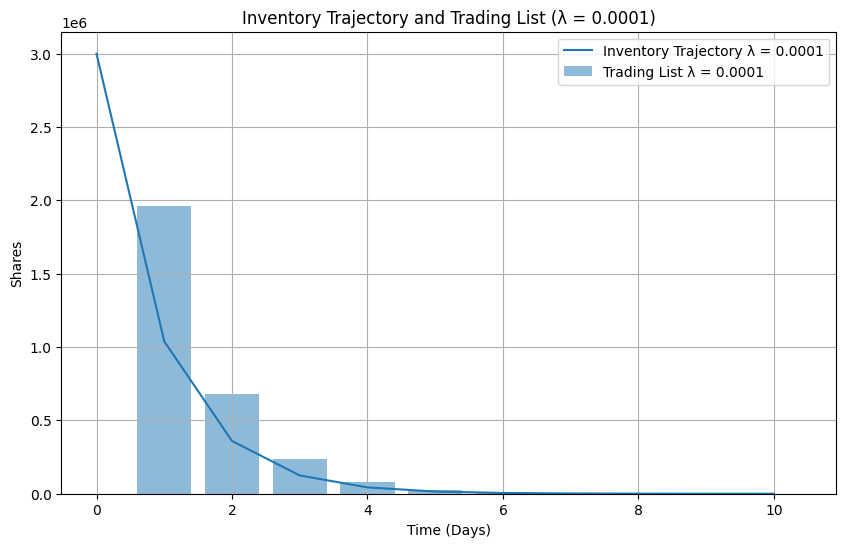

Time Step (t) | Inventory Trajectory (X_t) | Shares Traded (n_j) | λ = 0.0001
--------------------------------------------------
t =  0   | X_t =  3000000.0  | n_j = N/A
t =  1   | X_t =  1038698.733421733  | n_j =  1961301.266578264
t =  2   | X_t =  359631.6743900462  | n_j =  679067.0590316859
t =  3   | X_t =  124516.28313510386  | n_j =  235115.39125494222
t =  4   | X_t =  43111.52278314608  | n_j =  81404.76035195787
t =  5   | X_t =  14926.302874710793  | n_j =  28185.219908435276
t =  6   | X_t =  5167.037983190082  | n_j =  9759.264891520706
t =  7   | X_t =  1786.2855905854415  | n_j =  3380.7523926046397
t =  8   | X_t =  610.6350383873319  | n_j =  1175.6505521981098
t =  9   | X_t =  188.79029084966777  | n_j =  421.8447475376641
t =  10   | X_t =  0.0  | n_j =  188.79029084966777


In [151]:
#1(C) pt. 2

#3 million shares
X = 3000000  
#κ for λ = 0.001
kappa = kappa_values[0] 
#Values of t
times = np.arange(N + 1)

#X_t - number of shares remaining at time step t = 0,...,N
x_values = [] 
for t in times:
    #x_t = (sinh(κ * (T - t)) / sinh(κ * T)) * X
    x = (np.sinh(kappa * (T - t)) / np.sinh(kappa * T)) * X
    x_values.append(x)

#n_j - number of shares traded at each interval j = 1,...,N
trading_list = []
for j in range(1, N + 1):
    #n_j = (2 * sinh(0.5 * κ * τ) / sinh(κ * T)) * cosh(κ * (T - (j - 0.5) * τ)) * X
    n_j = (2 * np.sinh(0.5 * kappa * tau) / np.sinh(kappa * T)) * \
          np.cosh(kappa * (T - (j - 0.5) * tau)) * X
    trading_list.append(n_j)

#Plot inventory trajectory and trading list for λ = 0.001
#Citations: Utilized ChatGPT for efficient plotting and correct usage of matplotlib methods. 
plt.figure(figsize=(10, 6))
plt.plot(times, x_values, label="Inventory Trajectory for λ = 0.001")
trading_times = np.arange(1, N + 1)
plt.bar(trading_times, trading_list, alpha=0.5, label="Trading List for λ = 0.001")
plt.title("Inventory Trajectory and Trading List (λ = 0.001)")
plt.xlabel("Day")
plt.ylabel("Shares")
plt.legend()
plt.grid(True)
plt.show()

#Citations: Utilized ChatGPT for printing structure to show inventory trajectory and shares traded at each time interval.
print("Time Step (t) | Inventory Trajectory (X_t) | Shares Traded (n_j) |  λ = 0.001")
print("-" * 50)
for t in times:
    if t == 0:
        print("t = ", t, "  | X_t = ", x_values[t], " | n_j = N/A")
    elif t <= N:
        print("t = ", t, "  | X_t = ", x_values[t], " | n_j = ", trading_list[t - 1])
        
#κ for λ = 0.0001
kappa = kappa_values[1] 

#X_t - number of shares remaining at time step t = 0,...,N
x_values = [] 
for t in times:
    x = (np.sinh(kappa * (T - t)) / np.sinh(kappa * T)) * X
    x_values.append(x)

#n_j - number of shares traded at each interval j = 1,...,N
trading_list = [] 
for j in range(1, N + 1):
    n_j = (2 * np.sinh(0.5 * kappa * tau) / np.sinh(kappa * T)) * \
          np.cosh(kappa * (T - (j - 0.5) * tau)) * X
    trading_list.append(n_j)

#Plot inventory trajectory and trading list for λ = 0.001
#Citations: Utilized ChatGPT for efficient plotting and correct usage of matplotlib methods. 
plt.figure(figsize=(10, 6))
plt.plot(times, x_values, label="Inventory Trajectory λ = 0.0001")
trading_times = np.arange(1, N + 1)
plt.bar(trading_times, trading_list, alpha=0.5, label="Trading List λ = 0.0001")
plt.title("Inventory Trajectory and Trading List (λ = 0.0001)")
plt.xlabel("Time (Days)")
plt.ylabel("Shares")
plt.legend()
plt.grid(True)
plt.show()

#Citations: Utilized ChatGPT for printing structure to show inventory trajectory and shares traded at each time interval.
print("Time Step (t) | Inventory Trajectory (X_t) | Shares Traded (n_j) | λ = 0.0001")
print("-" * 50)
for t in times:
    if t == 0:
        print("t = ", t, "  | X_t = ", x_values[t], " | n_j = N/A")
    elif t <= N:
        print("t = ", t, "  | X_t = ", x_values[t], " | n_j = ", trading_list[t - 1])

In [152]:
#1(D) 

print("The Almgren-Chriss framework's purpose is to minimize a combination of market impact costs and variance risk.")
print("ϵ is a constant term in the total cost function, regardless of the trading trajectory.")
print("In the derivation of optimal trajectory, only varying terms are considered in the calculation of x_t and n_j.")
print("ϵ is a constant added to the total cost without influence on the structure of n_j, which only depends on κ,τ,T, and X.")

The Almgren-Chriss framework's purpose is to minimize a combination of market impact costs and variance risk.
ϵ is a constant term in the total cost function, regardless of the trading trajectory.
In the derivation of optimal trajectory, only varying terms are considered in the calculation of x_t and n_j.
ϵ is a constant added to the total cost without influence on the structure of n_j, which only depends on κ,τ,T, and X.


In [153]:
#2

file_path = 'Bitcoin_Price.csv'
df = pd.read_csv(file_path)
#Cleaning by taking the average of values at each timestamp and data normalization. 
#Citations: Utilized ChatGPT to efficiently clean using pandas groupby method. Also utilized ChatGPT for normalization methods and correct syntax for fit_transform method. 
df_cleaned = df.groupby('datetime')['price'].mean().reset_index()
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(df_cleaned[['price']])
#Splitting normalized data into training and testing sets. 
train_data, test_data = train_test_split(normalized_data, test_size=0.2, shuffle=False)
#Lookback window for 10 timesteps
lookback = 10 

#Citations: Used ChatGPT to index the training/testing data and properly check errors. 
#X_train and Y_train calculation
X_train = []
y_train = [] 
for i in range(lookback, len(train_data)):
    X_train.append(train_data[i - lookback:i, 0]) 
    y_train.append(train_data[i, 0])
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = [] 
y_test = []
for i in range(lookback, len(test_data)):
    X_test.append(test_data[i - lookback:i, 0]) 
    y_test.append(test_data[i, 0])
X_test = np.array(X_test)
y_test = np.array(y_test)

#Reshape input to be [samples, timesteps, features] to prepare LSTM model implementation. 
#Citations: Utilized ChatGPT for reshaping method syntax and help with LSTM model implementation. 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#Build the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#Train the model
model.fit(X_train, y_train, batch_size=256, epochs=100, verbose=2, validation_data=(X_test, y_test))

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 - 1s - 9ms/step - loss: 0.7860 - val_loss: 0.0218
Epoch 2/100
75/75 - 0s - 2ms/step - loss: 0.2444 - val_loss: 0.0389
Epoch 3/100
75/75 - 0s - 2ms/step - loss: 0.0517 - val_loss: 0.1421
Epoch 4/100
75/75 - 0s - 2ms/step - loss: 0.0226 - val_loss: 0.1654
Epoch 5/100
75/75 - 0s - 3ms/step - loss: 0.0198 - val_loss: 0.1403
Epoch 6/100
75/75 - 0s - 3ms/step - loss: 0.0173 - val_loss: 0.1056
Epoch 7/100
75/75 - 0s - 2ms/step - loss: 0.0139 - val_loss: 0.0723
Epoch 8/100
75/75 - 0s - 2ms/step - loss: 0.0102 - val_loss: 0.0480
Epoch 9/100
75/75 - 0s - 2ms/step - loss: 0.0070 - val_loss: 0.0313
Epoch 10/100
75/75 - 0s - 1ms/step - loss: 0.0045 - val_loss: 0.0203
Epoch 11/100
75/75 - 0s - 2ms/step - loss: 0.0027 - val_loss: 0.0125
Epoch 12/100
75/75 - 0s - 2ms/step - loss: 0.0016 - val_loss: 0.0077
Epoch 13/100
75/75 - 0s - 2ms/step - loss: 8.7024e-04 - val_loss: 0.0047
Epoch 14/100
75/75 - 0s - 2ms/step - loss: 5.0231e-04 - val_loss: 0.0033
Epoch 15/100
75/75 - 0s - 2ms/step - loss: 3.34

In [154]:
#2(A)

#Prediction storage
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

#Inverse transform predictions and true values to the original scale
#Citations: Utilized ChatGPT to format scaler.inverse_transform effectively, as well as the reshape method. 
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

#Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
#Calculation of RMSE as a percentage of the mean price for easier interpretation. According to ChatGPT,
#a target RMSE (in terms of a % of the mean price) to classify a model's performance as satisfactory is <5%. 
mean_price = df_cleaned['price'].mean() 
train_rmse_percent = (train_rmse / mean_price)
test_rmse_percent = (test_rmse / mean_price)
print("Train RMSE (decimal % of Mean Price):", train_rmse_percent)
print("Test RMSE (decimal % of Mean Price):", test_rmse_percent)

#Comments on results:
print("")
print("The training and testing RMSE is very low.")
print("Overall, I would say that a decimal % of RMSE (relative to the mean value of the data) should be less than 5% (confirmed by ChatGPT).")
print("We see a Train RMSE (decimal % of Mean Price) = ", str(train_rmse_percent))
print("We see a Test RMSE (decimal % of Mean Price) = ", str(test_rmse_percent))
print("This means that the performance of this model is more than satisfactory.")
print("")
print("However, the testing RMSE is", str(test_rmse_percent/train_rmse_percent), "times as large as the training RMSE.")
print("The gap between test and train RMSE suggests evidence of overfitting.")
print("Overfitting happens when the model learns patterns specific to the training data but fails to generalize to the testing data.")
print("The stark increase from train to test RMSE suggests that exactly this is happening, indicating evidence of overfitting.")

596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
Train RMSE: 4.152982721942393
Test RMSE: 14.021425449381224
Train RMSE (decimal % of Mean Price): 0.0016332091046335814
Test RMSE (decimal % of Mean Price): 0.005514089808965035

The training and testing RMSE is very low.
Overall, I would say that a decimal % of RMSE (relative to the mean value of the data) should be less than 5% (confirmed by ChatGPT).
We see a Train RMSE (decimal % of Mean Price) =  0.0016332091046335814
We see a Test RMSE (decimal % of Mean Price) =  0.005514089808965035
This means that the performance of this model is more than satisfactory.

However, the testing RMSE is 3.3762301430484305 times as large as the training RMSE.
The gap between test and train RMSE suggests evidence of overfitting.
Overfitting happens when the model learns patterns specific to the training data but fails to generalize to the testing data.
The stark increase from train to test RMSE suggests that exactl

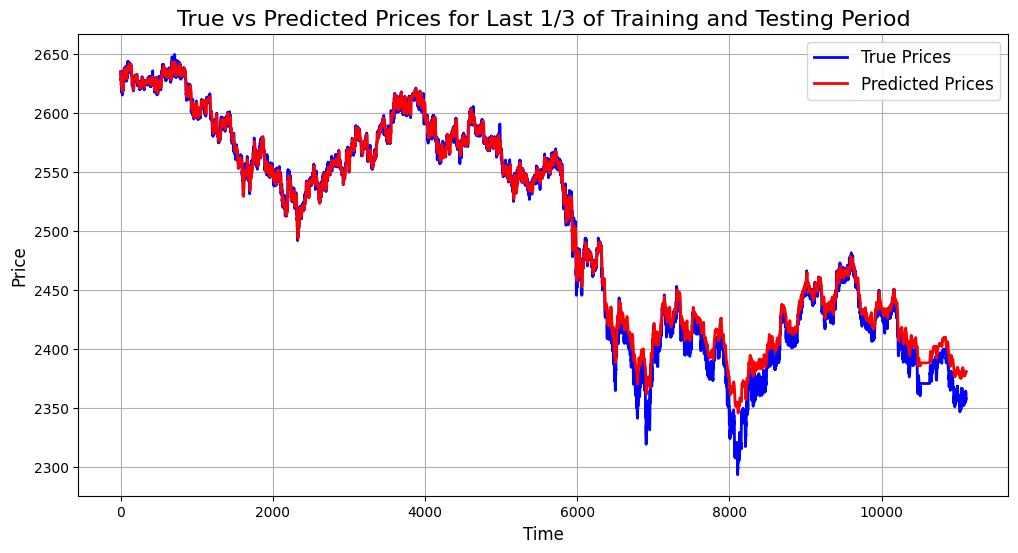

The deviations between the red and blue lines (especially before time = 6000) is relatively minimal, indicating good performance.
However, the discrepancies between the red and blue lines after time = 6000 are larger, indicating a dropoff in performance.
Overall, however, I would say that the performance looks good on the plot. I would say that improvements need to be made to
the gap between train and test RMSEs to prevent overfitting.


In [155]:
#2(B)

#Range for the last 1/3 of the training period.
train_plot_start = int(len(y_train) * (2 / 3))
#Concatenation of true values from the last 1/3 of training and the test period.
#Citations: Utilized ChatGPT to format properly for the numpy concatenate method and array referencing. 
true_values = np.concatenate((y_train[train_plot_start:], y_test), axis=0)
predicted_values = np.concatenate((train_predictions[train_plot_start:], test_predictions), axis=0)

#Plot the true and predicted price sequences (blue and red). 
#Citations: Utilized ChatGPT for efficient plotting and correct usage of matplotlib methods. 
plt.figure(figsize=(12, 6))
plt.plot(range(len(true_values)), true_values, label="True Prices", color="blue", linewidth=2)
plt.plot(range(len(predicted_values)), predicted_values, label="Predicted Prices", color="red", linewidth=2)
plt.title("True vs Predicted Prices for Last 1/3 of Training and Testing Period", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

#Comments on results:
print("The deviations between the red and blue lines (especially before time = 6000) is relatively minimal, indicating good performance.")
print("However, the discrepancies between the red and blue lines after time = 6000 are larger, indicating a dropoff in performance.")
print("Overall, however, I would say that the performance looks good on the plot. I would say that improvements need to be made to")
print("the gap between train and test RMSEs to prevent overfitting.")